# EIT-binary

This is an example file explaining how to work with the EIT-binary package. Data is loaded from an example file.

Data is loaded as a sequence of consecutive frames.
A sequence can consist of an entire measurement or be split up as separate sections of a measurement.


In [4]:
from pathlib import Path

from eitprocessing.datahandling.loading import load_eit_data
from eitprocessing.datahandling.continuousdata import ContinuousData
from eitprocessing.datahandling.eitdata import EITData


### Download data and load it into eitprocessing

We have some sample data store at XXX. Alternatively, you can use your own data in this notebook.


In [5]:
# TODO: make this cell download remote data and then load it
vendor = "draeger"

# data_directory = Path.cwd().parent / "tests" / "test_data" / "pig"
# path = Path(data_directory) / "pig_04_22.bin"

data_directory = Path.cwd().parent / "tests" / "test_data"
path = data_directory / "Draeger_Test3.bin"

measurement = load_eit_data(path, vendor=vendor)

len(measurement)

1820

A sequence can be sliced to select a subset of frames.


In [6]:
short_section = measurement[:500]
len(short_section)

500

A sequence contains information about the entire measurement and/or the selected section: the number of frames, which framesets are available, the time range, path to the source file, and sample frequency.
Some attributes are hidden when printing to preserve screen space.


In [7]:
# TODO: I think this cell was just for testing purposes

import numpy as np

np.set_printoptions(threshold=10)  # prevents printing of the entire time array

from pprint import pprint

pprint(measurement)
pprint(short_section)

Sequence(label='Sequence_140600721154656')
Sequence(label='Sequence_140600721154656')


## Framesets

Data is contained within framesets.
A frameset contains data that has been processed or edited in some way.
By default, loaded data only contains raw impedance data, without any processing.

Impedance data is available as the `pixel_impedance` attribute, which is a `np.ndarray` with three dimensions: time, rows, columns.

#TODO: Framesets don't exist any more, I think they are roughly equivalent to a DataCollection


In [8]:
raw_impedance_data: EITData = short_section.eit_data["raw"]

pprint(raw_impedance_data)
print(type(raw_impedance_data))
print(type(short_section.eit_data))
print("shape:", raw_impedance_data.pixel_impedance.shape, "=> (index, row, colum)")

EITData(label='raw')
<class 'eitprocessing.datahandling.eitdata.EITData'>
<class 'eitprocessing.datahandling.datacollection.DataCollection'>
shape: (500, 32, 32) => (index, row, colum)


You can deepcopy a frameset to create differently processed framesets.
Deepcopying prevents sharing mutable attributes, e.g. the `params` dict.
The example below uses the `Framset.pixel_baseline` property, which contains the lowest value per pixel over all frames in the sequence.


In [9]:
bc = raw_impedance_data.deepcopy()
pixel_baseline = bc.pixel_impedance.min(axis=0)

bc.name = "baseline_corrected"
bc.description = "raw data with a baseline correction for this section"
bc.label = "bc"
bc.pixel_impedance = bc.pixel_impedance - pixel_baseline
short_section.eit_data.add(bc)

pprint(short_section.eit_data)

{'raw': EITData(label='raw'), 'bc': EITData(label='bc')}


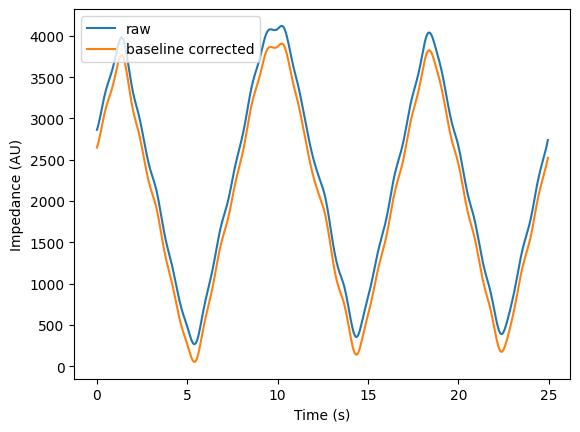

In [10]:
from matplotlib import pyplot as plt

x = short_section.time - short_section.time[0]

plt.plot(x, raw_impedance_data.calculate_global_impedance(), label="raw")
plt.plot(x, bc.calculate_global_impedance(), label="baseline corrected")
plt.xlabel("Time (s)")
plt.ylabel("Impedance (AU)")
plt.legend()

## Pixel data

Pixel impedance data can be accessed by indexing pixel_impedance by row and column numbers.
Both are zero-indexed, with (0, 0) being the top left of the image (anterior right of the subject).


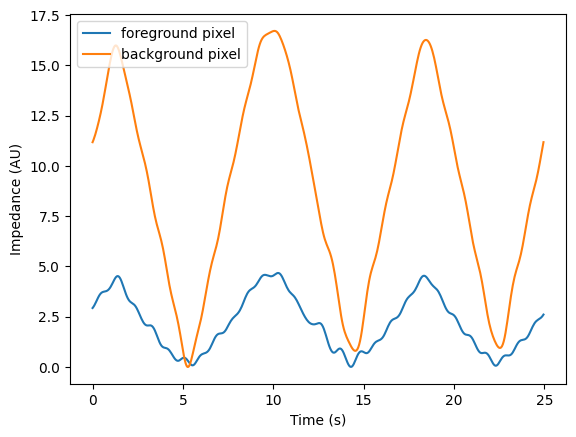

In [11]:
pixel_A = bc.pixel_impedance[:, 17, 10]  # foreground pixel
pixel_B = bc.pixel_impedance[:, 12, 20]  # background pixel


plt.plot(x, pixel_A, label="foreground pixel")
plt.plot(x, pixel_B, label="background pixel")
plt.xlabel("Time (s)")
plt.ylabel("Impedance (AU)")
plt.legend()


## Events

If a sequence contains events, they are loaded and available in the `events` attribute.


In [ ]:
pprint(measurement.sparse_data)
type(measurement.sparse_data["maxvalues_(draeger)"])

X = measurement.sparse_data["maxvalues_(draeger)"]

pprint(measurement.sparse_data["maxvalues_(draeger)"])

plt.plot(measurement.time, raw_impedance_data.calculate_global_impedance())
for event in measurement.sparse_data["maxvalues_(draeger)"]:
    plt.axvline(event.time, color="g")

When slicing a sequence, the list of events is also sliced and reindexed, so only events occurring during a sequence are available.


In [ ]:
pprint(measurement[6000:8000].events)

## End of inspiration and end of expiration

Dräger EIT files have "minmax" indicators indicating the start and end of breaths.
They are loaded in the `phases` attribute.
The reliability of these indicators is limited.


In [ ]:
from eitprocessing.binreader import MaxValue, MinValue

pprint(short_section.phases)

plt.plot(short_section.time, short_section.framesets["bc"].global_impedance)

for indicator in filter(lambda x: isinstance(x, MaxValue), short_section.phases):
    plt.axvline(short_section.time[indicator.index], 0.95, 1, color="r")

for indicator in filter(lambda x: isinstance(x, MinValue), short_section.phases):
    plt.axvline(short_section.time[indicator.index], 0.0, 0.05, color="g")

## Accessing and plotting single frames


In [ ]:
# Select the first MinValue and first MaxValue objects
min_value = next(filter(lambda x: isinstance(x, MinValue), short_section.phases))
max_value = next(filter(lambda x: isinstance(x, MaxValue), short_section.phases))

# Select the pixel data for the selected frames
min_data = short_section.framesets["bc"].pixel_impedance[min_value.index, :, :]
max_data = short_section.framesets["bc"].pixel_impedance[max_value.index, :, :]

# Get overall minimum and maximum values
vmin = np.min([min_data, max_data])
vmax = np.max([min_data, max_data])

# Create subplots
fig, ax = plt.subplots(1, 2)

# Create image
ax[0].imshow(min_data, vmin=vmin, vmax=vmax)
ax[1].imshow(max_data, vmin=vmin, vmax=vmax)

ax[0].set(title="End-expiration")
ax[1].set(title="End-inspiration")

## Animating frameset


In [ ]:
short_section.framesets["bc"].animate()

## Simple filtering


In [ ]:
from scipy import signal
from eitprocessing.binreader import Frameset

filter_ = signal.butter(5, 40 / 60, "lowpass", fs=20, output="sos")
filtered_pixel_impedance = signal.sosfiltfilt(filter_, short_section.framesets["raw"].pixel_impedance, axis=0)

short_section.framesets["lp-filtered"] = Frameset(
    name="lp-filtered",
    description="lowpass filtered",
    params={"filter": [{"type": "butterworth_lowpass", "cutoff": 40 / 60}]},
    pixel_impedance=filtered_pixel_impedance,
)

plt.plot(short_section.time, short_section.framesets["raw"].global_impedance, label="raw")
plt.plot(short_section.time, short_section.framesets["lp-filtered"].global_impedance, label="low-pass filtered")
plt.legend()

In [ ]:
from copy import deepcopy
from pathlib import Path
from pprint import pprint

import numpy as np
from matplotlib import pyplot as plt

from eitprocessing.datahandling.eitdata import EITData
from eitprocessing.datahandling.loading import load_eit_data

np.set_printoptions(threshold=0)  # prevents printing of the entire time array


In [ ]:
def plot_gi(data):
    t0 = data.time[0]
    plt.plot(data.time - t0, data)

### Download data and load it into eitprocessing

We have some sample data store at XXX. Alternatively, you can use your own data in this notebook.


In [ ]:
# make this cell download remote data and then load it
vendor = "draeger"

data_directory = Path.cwd().parent / "tests" / "test_data"
path = Path(data_directory) / "Draeger_Test.bin"
measurement = load_eit_data(path, vendor=vendor)


A sequence can be sliced to select a subset of frames.


In [ ]:
short_section = measurement[6883:7300]


A sequence contains information about the entire measurement and/or the selected section: the number of frames, which eit_data are available, the time range, path to the source file, and framerate.
Some attributes are hidden when printing to preserve screen space.


In [ ]:
print(measurement, f"{len(measurement)=}")
print(short_section, f"{len(short_section)=}")

## eit_data

Data is contained within eit_data.
A frameset contains data that has been processed or edited in some way.
By default, loaded data only contains raw impedance data, without any processing.

Impedance data is available as the `pixel_impedance` attribute, which is a `np.ndarray` with three dimensions: time, rows, columns.


In [ ]:
pprint(short_section.eit_data["raw"])
print("shape:", short_section.eit_data["raw"].pixel_impedance.shape, "=> (index, row, colum)")


You can deepcopy a frameset to create differently processed eit_data.
Deepcopying prevents sharing mutable attributes, e.g. the `params` dict.
The example below uses the `Frameset.pixel_baseline` property, which contains the lowest value per pixel over all frames in the sequence.


In [ ]:
bc: EITData = deepcopy(short_section.eit_data["raw"])
bc.name = "baseline_corrected"
bc.description = "raw data with a baseline correction for this section" # TODO: why does this work?
bc.pixel_impedance = bc.pixel_impedance - short_section.sparse_data.
bc.params.update({"pre-processing": "pixel baseline correction"})
short_section.eit_data["bc"] = bc

pprint(short_section.eit_data)

In [ ]:
from matplotlib import pyplot as plt

plt.plot(short_section.time, short_section.eit_data["raw"].global_impedance, label="raw")
plt.plot(short_section.time, short_section.eit_data["bc"].global_impedance, label="baseline corrected")
plt.xlabel("Time (s)")
plt.ylabel("Impedance (AU)")
plt.legend()

## Pixel data

Pixel impedance data can be accessed by indexing pixel_impedance by row and column numbers.
Both are zero-indexed, with (0, 0) being the top left of the image (anterior right of the subject).


In [ ]:
pixel_A = short_section.eit_data["bc"].pixel_impedance[:, 17, 10]
pixel_B = short_section.eit_data["bc"].pixel_impedance[:, 12, 20]

plt.plot(short_section.time, pixel_a)
plt.plot(short_section.time, pixel_b)

## Events

If a sequence contains events, they are loaded and available in the `events` attribute.


In [ ]:
pprint(measurement.events)

plt.plot(measurement.time, measurement.eit_data["raw"].global_impedance)
for event in measurement.events:
    plt.axvline(measurement.time[event.index], color="g")

When slicing a sequence, the list of events is also sliced and reindexed, so only events occurring during a sequence are available.


In [ ]:
pprint(measurement[6000:8000].events)

## End of inspiration and end of expiration

Dräger EIT files have "minmax" indicators indicating the start and end of breaths.
They are loaded in the `phases` attribute.
The reliability of these indicators is limited.


In [ ]:
from eitprocessing.binreader import MaxValue, MinValue

pprint(short_section.phases)

plt.plot(short_section.time, short_section.eit_data["bc"].global_impedance)

for indicator in filter(lambda x: isinstance(x, MaxValue), short_section.phases):
    plt.axvline(short_section.time[indicator.index], 0.95, 1, color="r")

for indicator in filter(lambda x: isinstance(x, MinValue), short_section.phases):
    plt.axvline(short_section.time[indicator.index], 0.0, 0.05, color="g")

## Accessing and plotting single frames


In [ ]:
# Select the first MinValue and first MaxValue objects
min_value = next(filter(lambda x: isinstance(x, MinValue), short_section.phases))
max_value = next(filter(lambda x: isinstance(x, MaxValue), short_section.phases))

# Select the pixel data for the selected frames
min_data = short_section.eit_data["bc"].pixel_impedance[min_value.index, :, :]
max_data = short_section.eit_data["bc"].pixel_impedance[max_value.index, :, :]

# Get overall minimum and maximum values
vmin = np.min([min_data, max_data])
vmax = np.max([min_data, max_data])

# Create subplots
fig, ax = plt.subplots(1, 2)

# Create image
ax[0].imshow(min_data, vmin=vmin, vmax=vmax)
ax[1].imshow(max_data, vmin=vmin, vmax=vmax)

ax[0].set(title="End-expiration")
ax[1].set(title="End-inspiration")

## Animating frameset


In [ ]:
short_section.eit_data["bc"].animate()

## Simple filtering


In [ ]:
from scipy import signal

from eitprocessing.binreader import Frameset

filter_ = signal.butter(5, 40 / 60, "lowpass", fs=20, output="sos")
filtered_pixel_impedance = signal.sosfiltfilt(filter_, short_section.eit_data["raw"].pixel_impedance, axis=0)

short_section.eit_data["lp-filtered"] = Frameset(
    name="lp-filtered",
    description="lowpass filtered",
    params={"filter": [{"type": "butterworth_lowpass", "cutoff": 40 / 60}]},
    pixel_impedance=filtered_pixel_impedance,
)

plt.plot(short_section.time, short_section.eit_data["raw"].global_impedance, label="raw")
plt.plot(short_section.time, short_section.eit_data["lp-filtered"].global_impedance, label="low-pass filtered")
plt.legend()